# Exercise 6 - Python: Support Vector Machines

<img width="600" src="http://1.bp.blogspot.com/-EGeuaZkSmCY/TtcfqaeCUCI/AAAAAAAADSo/_mkhp4L-3rc/s1600/Kernel_Machine.png">

## *Part I*: Support Vector Machines

In this exercise, we'll fit support vector machines to three unnamed datasets:
1. Linear Separable
2. Non-linear Separable
3. Non-linear Separable


This exercise is a little different than the previous ones because we are moving away from building everything from scratch and towards using existing libraries.  We will be using [scikit-learn](http://scikit-learn.org/stable/) 
to train our support vector machines and to perform [grid searches](http://scikit-learn.org/stable/modules/grid_search.html) in order to tune the hyperparameters in some cases.


---

Beginning with package imports and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio  # Used to load the Octave/MATLAB *.mat files
from sklearn import svm  # Trains SVM models

# Finds optimal parameters using pre-defined validaiton datasets
from sklearn.model_selection import GridSearchCV, PredefinedSplit

%matplotlib inline

sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

In [2]:
# Loading the matrices for the three data sets
data1 = sio.loadmat('ex6/ex6data1.mat')
data2 = sio.loadmat('ex6/ex6data2.mat')
data3 = sio.loadmat('ex6/ex6data3.mat')

### Linear Separable Data

### Dataset I

Visualizing the data:

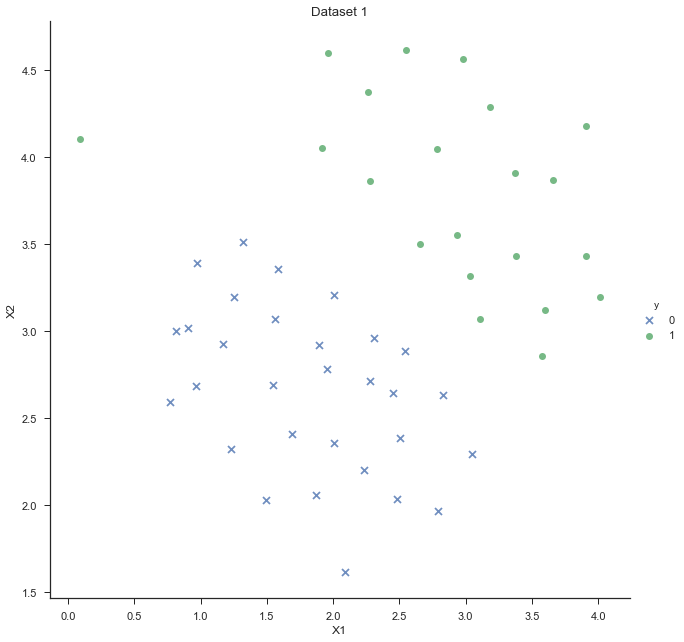

In [3]:
# Assigning X and y for the first data set
X = data1['X']
y = data1['y']

# Putting into a data frame for plots
df = pd.DataFrame({'X1': X[:, 0], 'X2': X[:, 1], 'y': y.flatten()})

# Plotting the original data
sns.lmplot(x='X1', y='X2', hue='y', markers=['x', 'o'],
           data=df, fit_reg=False, size=9)

plt.title('Dataset 1')

Notice the outlier in the top left of the graph.  This will largely dictate how our values of C act.  Specifically, if we use a very low value of $C$, the trained support vector machine will be considered a [soft margin classifier](https://nlp.stanford.edu/IR-book/html/htmledition/soft-margin-classification-1.html) and the outlier will be considered a slack variable.  If we use very large values of C, then the trained support vector machine will be considered a [hard margin classifier](https://en.wikipedia.org/wiki/Support_vector_machine#Hard-margin).

#### Fitting and plotting the decision boundary

We'll train the SVM at different values of $C$, and plotting the decision boundary along with the margins.  Here's a typical hard margin support vector machine visual for comparison:

<img src="http://dni-institute.in/blogs/wp-content/uploads/2015/09/SVM-Planes.png">

Notice that the closest points to the decision boundary are called support vectors.  These make support vector machines very memory efficient because you only need to know which samples are support vectors in order to classify additional points in the future.

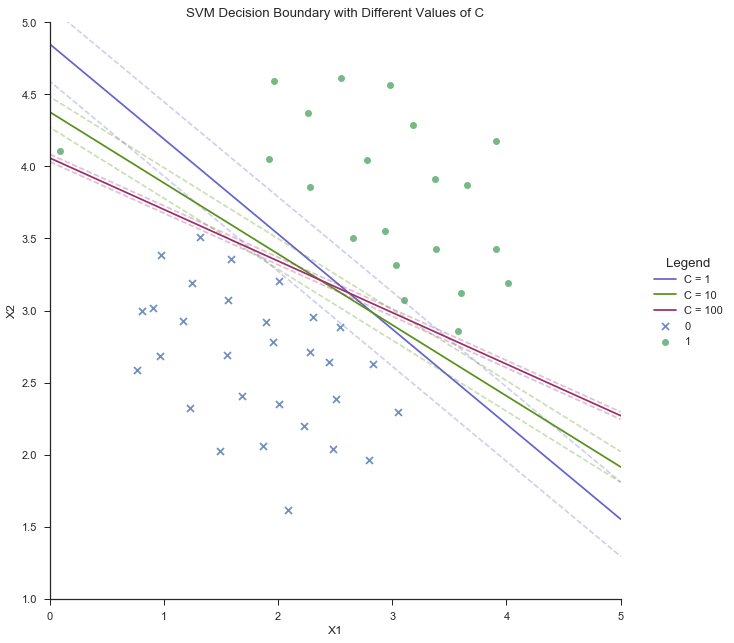

In [4]:
# Plotting the original data
fig = sns.lmplot(x='X1', y='X2', hue='y', markers=['x', 'o'],
                 data=df, fit_reg=False, size=9, legend=False)

for c in [1, 10, 100]:
    # Training the SVM
    clf = svm.SVC(kernel='linear', C=c)
    clf.fit(X, y.ravel())
    
    # Getting the linearly separable boundary
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-5, 5)
    yy = a * xx - (clf.intercept_[0]) / w[1]
    
    # plot the parallels to the separating hyperplane that pass through the
    # support vectors
    margin = 1 / np.sqrt(np.sum(clf.coef_**2))
    yy_down = yy + a * margin
    yy_up = yy - a * margin
    
    color = np.random.rand(3,1)
    
    # Plotting the boundary
    boundary = plt.plot(xx, yy, 'k-', c=color, label=("C = " + str(c)))
    
    # Plotting the boundary margins
    plt.plot(xx, yy_down, 'k--', alpha=0.3, c=color)
    plt.plot(xx, yy_up, 'k--', alpha=0.3, c=color)
    
# Adjusting the title and x/y axis limits
plt.title('SVM Decision Boundary with Different Values of C')
plt.xlim(0, 5)
plt.ylim(1, 5)

# Adjusting the legend location
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2,
           borderaxespad=0., title='Legend')

Notice two things about this plot:
    
1. The margins are significantly wider with lower values of C
2. C $= 100$ correctly the outlier on the upper left side of the graph, but the others misclassify it.  This is because our model is a soft margin classifier with $C \in [1, 10]$, thus making the outlier a slack variable.  When $C = 100$, it is correctly classified, but our margins are tiny.

### SVM with Gaussian Kernels (Non-linear Separable Data)

The [kernel method](https://en.wikipedia.org/wiki/Kernel_method) is a way of finding a linearly separable [hyperplane](https://en.wikipedia.org/wiki/Hyperplane) to separate classes in a nonlinear dataset by mapping it to a higher plane.

<img width="600px" src="http://i2.wp.com/blog.hackerearth.com/wp-content/uploads/2017/02/kernel.png">

[Here](https://www.youtube.com/watch?v=3liCbRZPrZA) is a video demonstrating the kernel method with a polynomial kernel.

I'll create a function for the Gaussian kernel by itself, but scikit-learn's [SVC (Support Vector Classifier)](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) has this kernel built in as the 'rbf' ([radial basis function](https://en.wikipedia.org/wiki/Radial_basis_function)) kernel.  You can plug custom kernels into the SVC function, but we'll go with the rbf kernel for the sake of simplicity.

### Dataset II

Unlike the other datasets, we are provided with specific parameters for fitting a support vector machine.

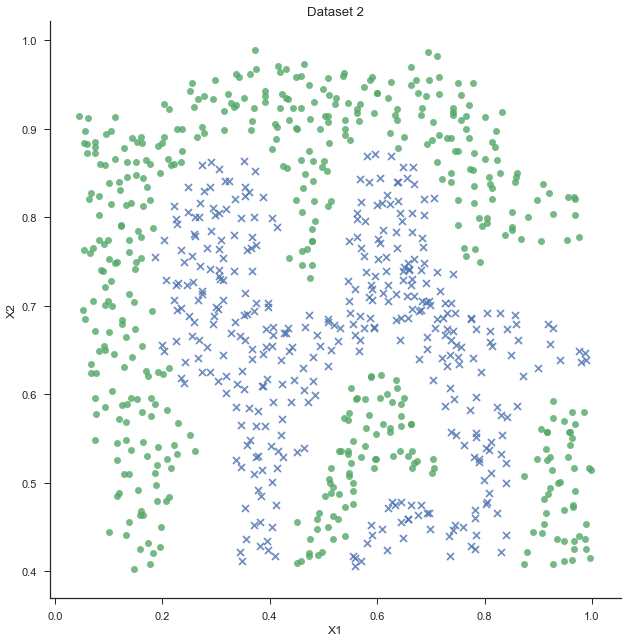

In [5]:
X = data2['X']
y = data2['y']

df = pd.DataFrame({'X1': X[:, 0], 'X2': X[:, 1], 'y': y.flatten()})

sns.lmplot(x='X1', y='X2', hue='y', markers=['x', 'o'],
                 data=df, fit_reg=False, size=9, legend=False)

plt.title('Dataset 2')

**Gaussian Kernel**

One way to think of the Gaussian kernel as a similarity function that measures the "distance" between a pair of examples, $(x^{(i)}, x^{(j)})$

$$K_{gaussian}(x^{(i)}, x^{(j)}) = \text{exp} \Big(- \frac{\|x^{(i)} - x^{(j)\|^2}}{2\sigma^2} \Big) = \text{exp} \Bigg(- \frac{\sum_{k=1}^n (x_k^{(i)} - x_k^{(j)})^2}{2\sigma^2} \Bigg)$$

In [6]:
def gaussian_kernel(x_i, x_j, sigma=1):
    """
    Similarity function to measure the 'distance' between a pair of examples
    """
    error = sum((x_i - x_j)**2)
    return np.exp(-(error) / (2*sigma**2))
    
    
test_x_i = np.array([1.0, 2.0, 1.0])
test_x_j = np.array([0.0, 4.0, -1.0])
test_sigma = 2

gaussian_kernel(test_x_i, test_x_j, test_sigma)

0.32465246735834974

#### Fitting and plotting the decision boundary

One thing to note is that SVC's gamma parameter takes the place of the sigma parameter in our Gaussian kernel function.  They're in different units, so we just have to multiply the sigmas provided in the exercise by 100.

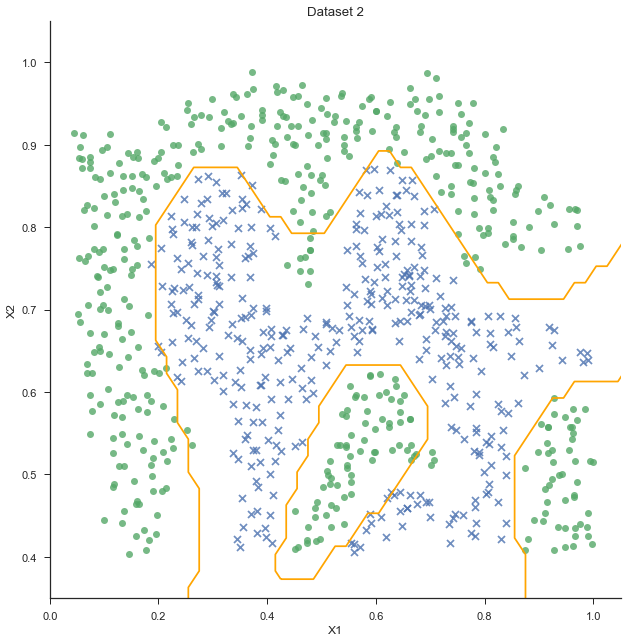

In [7]:
def plot_boundary(X, y, C=1, gamma=10, color='orange'):
    """
    Returns the arguments used for plotting the decision boundary using
    sklearn.SVM.SCV
    """
    # Creates and fits the model
    model = svm.SVC(kernel='rbf', C=C, gamma=gamma)
    model.fit(X, y.ravel())
    
    # Creates the mesh grid for the contour plot
    h = .02  # mesh grid step size
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Assigning a class probability to each point in the mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Reshaping for contour plot
    Z = Z.reshape(xx.shape)
    
    # Generating the contour plot
    boundary = plt.contour(xx, yy, Z, colors=color, alpha=1,
                           linewdiths=3, levels=[0.5])
    
    return boundary


# Plotting the original data
sns.lmplot(x='X1', y='X2', hue='y', markers=['x', 'o'],
                 data=df, fit_reg=False, size=9, legend=False)

# Adjusting plot properties
plt.title('Dataset 2')
plt.axis([0, 1.05, 0.35, 1.05])

# Plotting the boundary
plot_boundary(X, y, C=100)

### Dataset III

Rather than being provided with the parameters for this data set, we're provided with a set of parameters that we must test on the validation set.  In order to find the optimal parameters, we need to try all combinations of the set of parameters with a [grid search](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning).

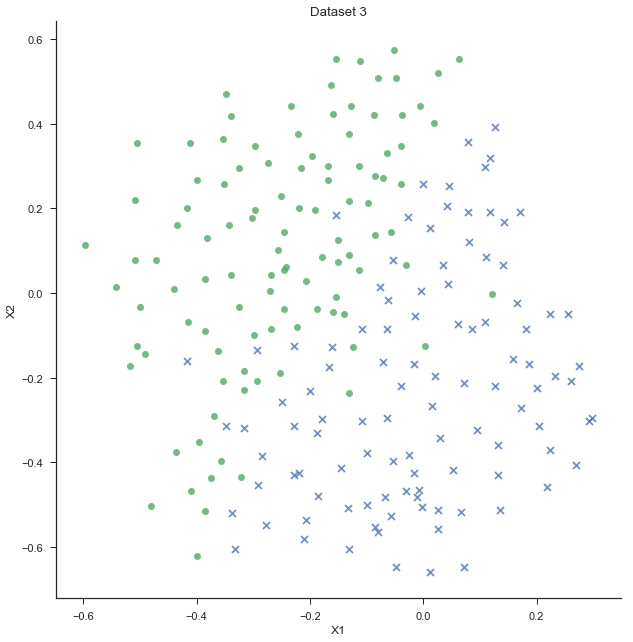

In [8]:
# Training data
X = data3['X']
y = data3['y']

# Validation data
Xval = data3['Xval']
yval = data3['yval']

df = pd.DataFrame({'X1': X[:, 0], 'X2': X[:, 1], 'y': y.flatten()})

sns.lmplot(x='X1', y='X2', hue='y', markers=['x', 'o'],
                 data=df, fit_reg=False, size=9, legend=False)

plt.title('Dataset 3')

#### Grid Search

We're provided with 8 values for $C$ and 8 values for $\sigma$, which results in $8^2 = 64$ combinations.

We'll use scikit-learn's [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function to accomplish this.

In [9]:
# Parameters to try
parameters = {'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30],
              'gamma': [1, 3, 10, 30, 100, 300, 1000, 3000],
              'kernel': ['rbf']}

# Model to use
model = svm.SVC()

# Setting up grid search for finding optimal parameters with the model
gridsearch = GridSearchCV(
    model,
    parameters,
    n_jobs=-1,  # Uses all available cores
    cv=PredefinedSplit(test_fold=yval.ravel()),  # Uses validation set
    verbose=10)  # Gives status updates

# Conducting the grid search
gridsearch.fit(X, y.ravel())

# Returning the optimal parameters
gridsearch.best_params_

Fitting 2 folds for each of 64 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1938s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0285s.) Setting batch_size=28.
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.4s finished


{'C': 1, 'gamma': 30, 'kernel': 'rbf'}

#### Fitting and plotting the decision boundary

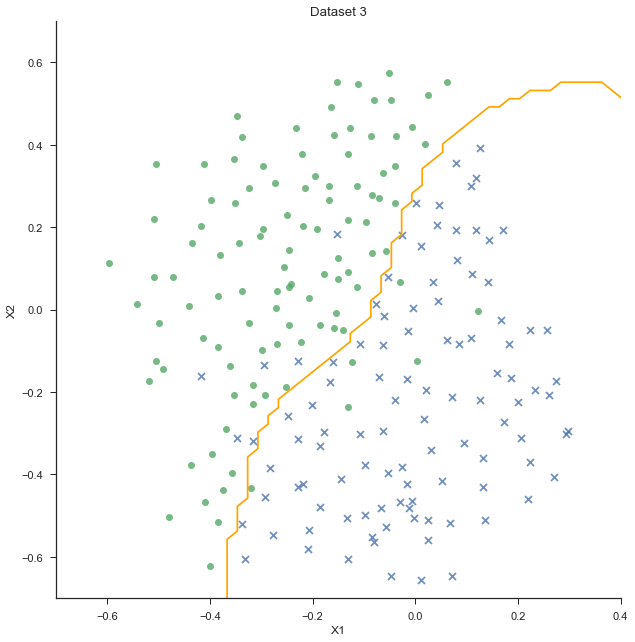

In [10]:
# Plotting the original data
sns.lmplot(x='X1', y='X2', hue='y', markers=['x', 'o'],
                 data=df, fit_reg=False, size=9, legend=False)

# Adjusting plot properties
plt.title('Dataset 3')
plt.axis([-0.7, 0.4, -0.7, 0.7])

# Plotting the boundary
plot_boundary(X, y, C=1, gamma=30)

---

##  *Part II:* Spam Classification

For this part, the email processing has already been accomplished, so we will only be training the model using the processed data.

Before we do, here are processing steps to give a better idea of the data:

1. **Lower-casing (normalizing):** Ignores capitalization to reduce the overall feature space
2. **Stripping HTML:** Removes unnecessary HTML tags
3. **Normalizing URLs:** Changes all URLs to "httpaddr"
4. **Normalizing Email Addresses:** Changes all email addresses to "emailaddr"
5. **Normalizing Numbers:** Changes all numbers to "number"
6. **Normalizing Dollars:** Changes all dollar signs (\$) to "dollar"
7. ** Word Stemming:** Reduces words to their stem (e.x. discounted $\rightarrow$ discount)
8. **Removal of non-words:** Removes punctuation, non-words, and trims white spaces

After that, each result was assigned an index.  Here is an example of the first 20 words along with their indexes:

In [11]:
# Reading in words along with their indexes
vocab = pd.read_table('ex6/vocab.txt', header=None, names=['Idx', 'Word'])

# Previewing number of words and first 10 words
print("Number of words:", vocab.shape[0])
vocab[:10]

Number of words: 1899


Idx     Word
0    1       aa
1    2       ab
2    3     abil
3    4      abl
4    5    about
5    6     abov
6    7  absolut
7    8     abus
8    9       ac
9   10   accept

Lastly, our training and testing sets were created by one-hot encoding each word:

|X   | 1 (aa) | 2 (ab) | 3 (abil) | 4 (abl) | ... | 1899 (zip) |
|----|--------|--------|----------|---------|-----|------------|  
|1   | 0      | 1      | 0        | 0       | ... | 1          |
|2   | 1      | 0      | 0        | 0       | ... | 0          |
|... | ...    | ...    | ...      | ...     | ... | ...        |
|4000| 0      | 0      | 1        | 0       | ... | 0          |

In [12]:
# Reading in training data
train = sio.loadmat('ex6/spamTrain.mat')
X = train['X']
y = train['y']

# Reading in testing data
test = sio.loadmat('ex6/spamTest.mat')
Xtest = test['Xtest']
ytest = test['ytest']

### Training SVM for Spam Classification

We'll begin with a grid search for finding optimal parameters for our model.  I won't use as many parameters as we did in part I because these models will take significantly longer to fit due to our number of parameters, $n = 1899$ instead of $n=2$.

We'll also use the linear kernel (also known as no kernel) since $n$ (the number of features) is so high.  As a reminder, it is recommended to use the linear kernel when $n$ is high and $m$ (the number of samples) is low, and the Gaussian kernel is recommended when $n$ is small and $m$ is large.

The other advantage of using a linear kernel in this case is that it gives us coefficients which tells us the most used words in spam emails.

In [13]:
# Parameters to try
parameters = {'C': [0.01, 0.1, 1, 10, 30, 100, 300],
              'kernel': ['linear']}

# Model to use
model = svm.SVC()

# Setting up grid search for finding optimal parameters with the model
gridsearch = GridSearchCV(
    model,
    parameters,
    n_jobs=-1,  # Uses all available cores
    verbose=10)  # Gives status updates

# Conducting the grid search
gridsearch.fit(X, y.ravel())

# Returning the optimal parameters
gridsearch.best_params_

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done  17 out of  21 | elapsed:  1.3min remaining:   18.1s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  1.4min finished


{'C': 0.1, 'kernel': 'linear'}

In [14]:
# Fitting the model with our obtained parameters
model = svm.SVC(kernel='linear', C=0.1)
model.fit(X, y.ravel())

# Testing the accuracy on the test set
print('Test set accuracy: ', model.score(Xtest, ytest))

Test set accuracy:  0.989


### Top Predictors for Spam

In [15]:
# Extracting the coefficient from the model
vocab['SpamCoef'] = model.coef_[0]

# Sorting by the largest coefficients
vocab.sort_values('SpamCoef', ascending=False)[:10]

Idx      Word  SpamCoef
1190  1191       our  0.500614
297    298     click  0.465916
1397  1398     remov  0.422869
738    739  guarante  0.383622
1795  1796     visit  0.367710
155    156  basenumb  0.345064
476    477    dollar  0.323632
1851  1852      will  0.269724
1298  1299     price  0.267298
1263  1264     pleas  0.261169